In [1]:
import tensorflow as tf

In [2]:
mnist = tf.keras.datasets.mnist

(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [3]:
X_train, X_test = X_train/255.0, X_test/255.0

In [4]:
mnistnn = tf.keras.models.Sequential([
               tf.keras.layers.Flatten(input_shape=(28,28,1)),                       
               tf.keras.layers.Dense(units=128, activation='relu'),
               tf.keras.layers.Dense(units=64, activation ='tanh'),
               tf.keras.layers.Dense(units=30, activation = 'relu'),    
               tf.keras.layers.Dense(units=10)                   
])

In [5]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(60000, 28, 28)
(10000, 28, 28)
(60000,)
(10000,)


In [6]:
mnistnn.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), optimizer='sgd', metrics=['accuracy'])

In [7]:
history = mnistnn.fit(x=X_train, y=y_train,
                      epochs=15, validation_split=0.2)

Epoch 1/15
1500/1500 [==============================] - 3s 2ms/step - loss: 0.7252 - accuracy: 0.8064 - val_loss: 0.3339 - val_accuracy: 0.9072
Epoch 2/15
1500/1500 [==============================] - 3s 2ms/step - loss: 0.3026 - accuracy: 0.9121 - val_loss: 0.2460 - val_accuracy: 0.9306
Epoch 3/15
1500/1500 [==============================] - 3s 2ms/step - loss: 0.2354 - accuracy: 0.9315 - val_loss: 0.2106 - val_accuracy: 0.9402
Epoch 4/15
1500/1500 [==============================] - 3s 2ms/step - loss: 0.1954 - accuracy: 0.9424 - val_loss: 0.1785 - val_accuracy: 0.9482
Epoch 5/15
1500/1500 [==============================] - 3s 2ms/step - loss: 0.1670 - accuracy: 0.9509 - val_loss: 0.1594 - val_accuracy: 0.9552
Epoch 6/15
1500/1500 [==============================] - 3s 2ms/step - loss: 0.1450 - accuracy: 0.9570 - val_loss: 0.1440 - val_accuracy: 0.9592
Epoch 7/15
1500/1500 [==============================] - 3s 2ms/step - loss: 0.1278 - accuracy: 0.9625 - val_loss: 0.1372 - val_accuracy:

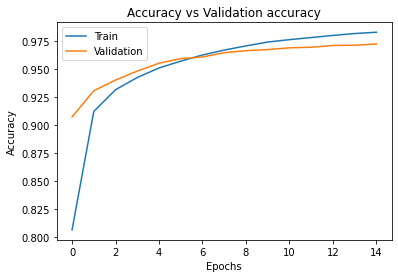

In [8]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Validation accuracy')
plt.legend(['Train','Validation'])
plt.show()

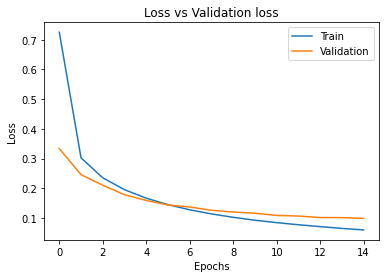

In [9]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss vs Validation loss')
plt.legend(['Train','Validation'])
plt.show()

In [10]:
mnistnn.evaluate(X_test, y_test)

313/313 [==============================] - 0s 2ms/step - loss: 0.0950 - accuracy: 0.9695


[0.09502257406711578, 0.9695000052452087]

In [11]:
mnistnn.save('mnistnn.h5', save_format='h5')

In [12]:
from keras.models import load_model

newmodel = load_model('mnistnn.h5')

In [13]:
newmodel.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 128)               100480    
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_2 (Dense)              (None, 30)                1950      
_________________________________________________________________
dense_3 (Dense)              (None, 10)                310       
Total params: 110,996
Trainable params: 110,996
Non-trainable params: 0
_________________________________________________________________


In [14]:
newmodel.evaluate(X_test, y_test)

313/313 [==============================] - 0s 1ms/step - loss: 0.0950 - accuracy: 0.0985


[0.09502257406711578, 0.09849999845027924]

In [15]:
ypred = mnistnn.predict_classes(X_test)

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


##DEPLOYMENT

In [16]:
!pip install flask gevent requests pillow

In [17]:
procfile = 'web: gunicorn app:app'
procfiles= open("/content/Procfile","w")
procfiles.write(procfile)
procfiles.close()

##Install flask and ngrok

In [18]:
!pip install flask-ngrok
from flask_ngrok import run_with_ngrok
from flask import Flask

##WEBPAGE

In [19]:
a = '''
<!doctype html>
<html lang="en">
<head>
</head> 
  <body>
 
          <h3>Image Recognition Server</h3>
       
      <form action="" method=post enctype=multipart/form-data>
        <input type=file name=file>
        <input type=submit value=Upload>
    </form>
    {{label}}  
     
  </body>
  </html>
  '''

In [20]:
!mkdir '/content/templates'
!mkdir '/content/uploads'

Html_file = open("/content/templates/index.html", "w")
Html_file.write(a)
Html_file.close()

mkdir: cannot create directory ‘/content/templates’: File exists
mkdir: cannot create directory ‘/content/uploads’: File exists


##DEPLOY MODEL

In [21]:
import os
from flask import Flask, render_template, request
from keras.preprocessing import image
from keras.preprocessing.image import load_img, img_to_array
import numpy as np

app = Flask(__name__)
run_with_ngrok(app)
app.config['UPLOADS'] = 'uploads'


def load_mymodel():
    global mymodel
    mymodel = load_model('mnistnn.h5')

@app.route('/')
def home():
    return render_template('index.html')

def predictions(file):
    img = image.load_img(file, target_size=(28,28), color_mode="grayscale")
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    ans = mymodel.predict_classes(img)
    return ans


@app.route('/', methods=['POST'])
def upload_files():
    file = request.files['file']
    filepath = os.path.join(app.config['UPLOADS'], file.filename)
    file.save(filepath)
    output = predictions(filepath)
    return render_template('index.html', label=output)



if __name__=='__main__':
    load_mymodel()
    app.run()

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.0.1:5000/ (Press CTRL+C to quit)


 * Running on http://c8aff077fe68.ngrok.io
 * Traffic stats available on http://127.0.0.1:4040


127.0.0.1 - - [13/Dec/2020 05:32:44] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [13/Dec/2020 05:32:44] "GET /favicon.ico HTTP/1.1" 404 -
127.0.0.1 - - [13/Dec/2020 05:32:53] "POST / HTTP/1.1" 200 -
127.0.0.1 - - [13/Dec/2020 05:33:06] "POST / HTTP/1.1" 200 -
